In [1]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) =boston_housing.load_data()

# normalize data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [3]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
k=4
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples], 
                                          train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], 
                                             train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [5]:
# all_mae_histories has demension of (k, epoch)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

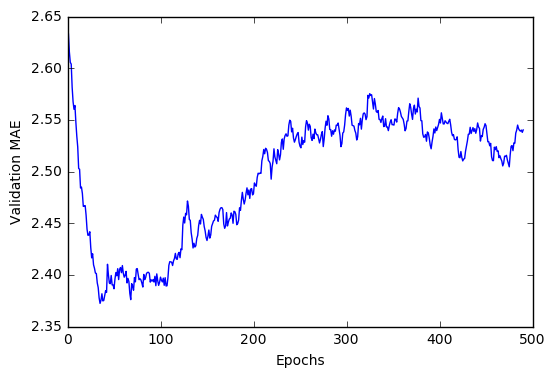

In [6]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [7]:
# retrain the model with all the data using the optimal epochs
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print (test_mae_score)


102/102 [==============================] - 0s 738us/step
2.96157860288433
